In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [2]:
from zipfile import ZipFile

data_path = 'lung_colon_image_set.zip'

with ZipFile(data_path,'r') as zipfile:
    zipfile.extractall('lung_colon_image_set')
    print('The data set has been extracted.')

The data set has been extracted.


In [3]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

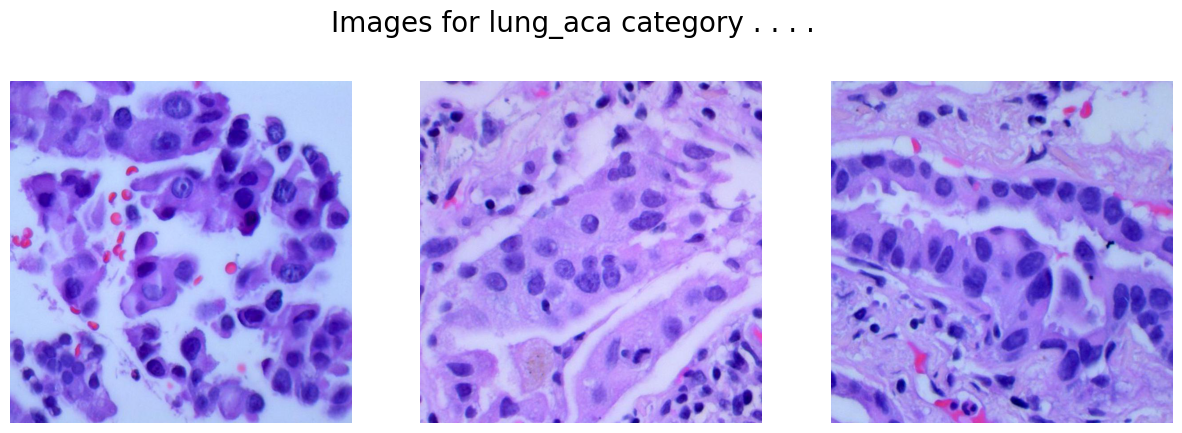

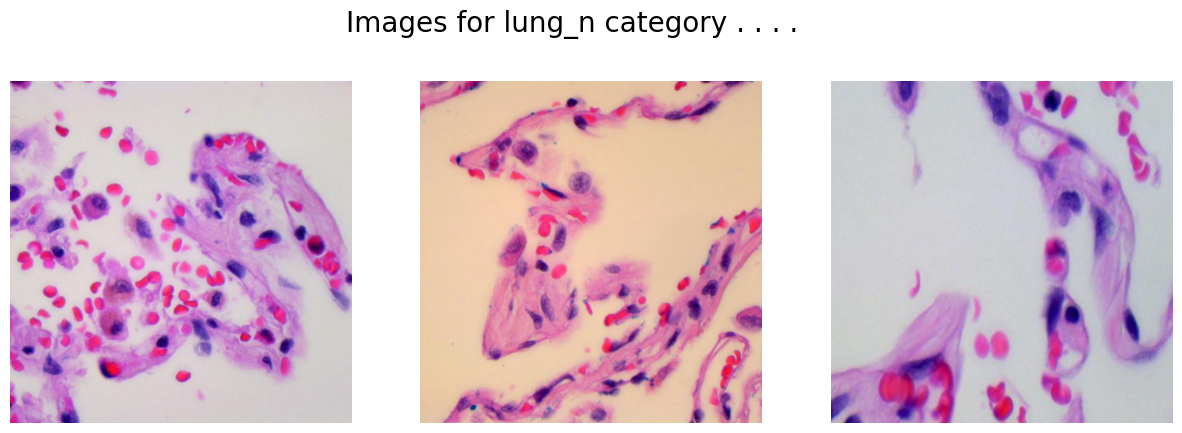

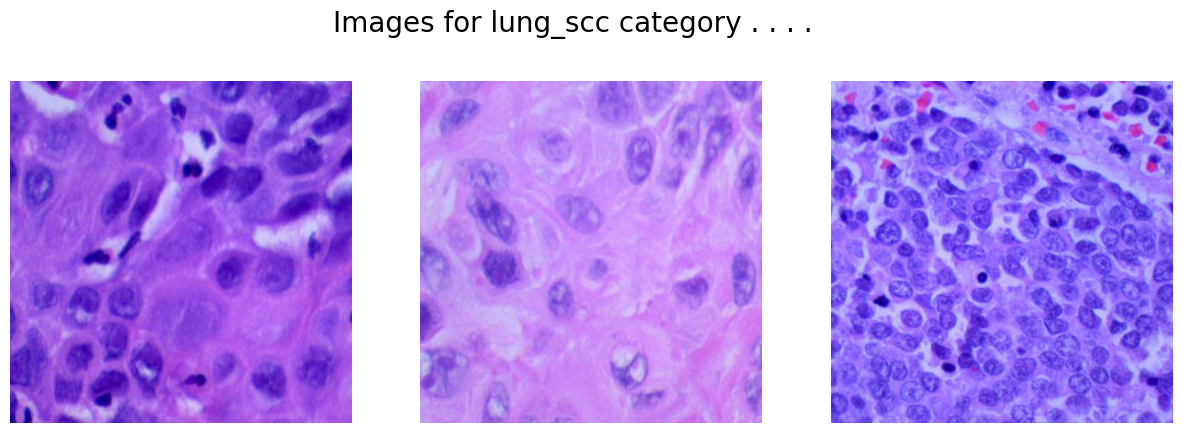

In [4]:
path = 'lung_colon_image_set/lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()

In [5]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [7]:
from tqdm import tqdm

X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in tqdm(images, desc=f'Loading Images ({cat}): '):
    	img = cv2.imread(image)
    	
    	X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    	Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

Loading Images (lung_scc): 100%|████████████████████████████████████████████████████████████████| 5000/5000 [00:57<00:00, 86.68it/s]


In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    one_hot_encoded_Y,
    test_size = SPLIT,
    random_state = 2022
)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [10]:
model = keras.models.Sequential([
	layers.Conv2D(
        filters=32,
		kernel_size=(5, 5),
		activation='relu',
		input_shape=(IMG_SIZE, IMG_SIZE, 3),
		padding='same'
    ),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(
        filters=64,
		kernel_size=(3, 3),
		activation='relu',
		padding='same'
    ),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(
        filters=128,
		kernel_size=(3, 3),
		activation='relu',
		padding='same'
    ),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,684,291 (128.50 MB)

 Trainable params: 33,683,523 (128.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [12]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(
    patience=3,
	monitor='val_accuracy',
	restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
	patience=2,
	factor=0.5,
	verbose=1
)

In [14]:
history = model.fit(
    X_train, Y_train,
	validation_data = (X_val, Y_val),
	batch_size = BATCH_SIZE,
	epochs = EPOCHS,
	verbose = 1,
	callbacks = [es, lr]
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 648s 3s/step - accuracy: 0.7740 - loss: 0.5341 - val_accuracy: 0.6357 - val_loss: 2.1537 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 643s 3s/step - accuracy: 0.9124 - loss: 0.2211 - val_accuracy: 0.6587 - val_loss: 5.3323 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 647s 3s/step - accuracy: 0.9289 - loss: 0.1820 - val_accuracy: 0.8963 - val_loss: 0.3665 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.9457 - loss: 0.1397 - val_accuracy: 0.8650 - val_loss: 0.3139 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 638s 3s/step - accuracy: 0.9600 - loss: 0.1064 - val_accuracy: 0.5733 - val_loss: 13.6449 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9655 - loss: 0.0946
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 644s 3s/step - accuracy: 0.9655 - loss: 0.09

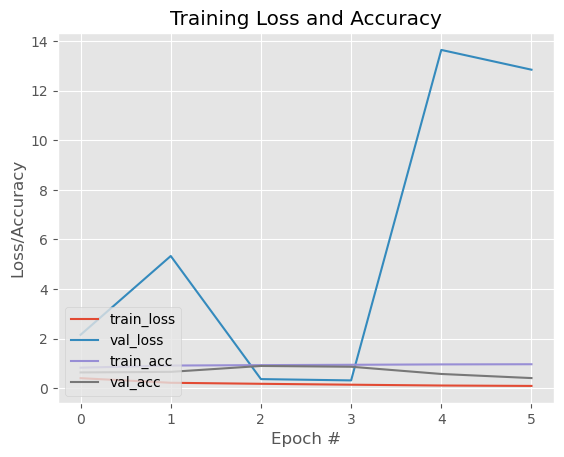

In [15]:
N = len(history.history['accuracy'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [16]:
Y_pred = model.predict(X_val)
Y_val_ = np.argmax(Y_val, axis=1)
Y_pred_ = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 278ms/step


In [17]:
metrics.confusion_matrix(Y_val_, Y_pred_)

array([[821,   0, 166],
       [ 70, 907,   0],
       [ 75,   0, 961]], dtype=int64)

In [19]:
print(
    metrics.classification_report(
        Y_val_,
        Y_pred_,
        target_names=classes
    )
)

              precision    recall  f1-score   support

    lung_aca       0.85      0.83      0.84       987
      lung_n       1.00      0.93      0.96       977
    lung_scc       0.85      0.93      0.89      1036

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

